Chosen classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Train shape: (10000, 32, 32, 3) Test shape: (2000, 32, 32, 3)

=== Training CNN ===
Epoch 1/20
157/157 - 6s - 39ms/step - acc: 0.2393 - loss: 2.4968 - val_acc: 0.4115 - val_loss: 1.9935
Epoch 2/20
157/157 - 1s - 7ms/step - acc: 0.4047 - loss: 1.9805 - val_acc: 0.4820 - val_loss: 1.7304
Epoch 3/20
157/157 - 1s - 6ms/step - acc: 0.4810 - loss: 1.6960 - val_acc: 0.5330 - val_loss: 1.5783
Epoch 4/20
157/157 - 1s - 4ms/step - acc: 0.5364 - loss: 1.5094 - val_acc: 0.5680 - val_loss: 1.4363
Epoch 5/20
157/157 - 1s - 8ms/step - acc: 0.5869 - loss: 1.3377 - val_acc: 0.5680 - val_loss: 1.4304
Epoch 6/20
157/157 - 1s - 8ms/step - acc: 0.6306 - loss: 1.1867 - val_acc: 0.5775 - val_loss: 1.3702
Epoch 7/20
157/157 - 1s - 4ms/step - acc: 0.6692 - loss: 1.0662 - val_acc: 0.5940 - val_loss: 1.3191
Epoch 8/20
157/157 - 1s - 8ms/step - acc: 0.7021 - loss: 0.9292 - val_acc: 0.6005 - val_loss: 1.3439
Epoch 9/20
157/157 -

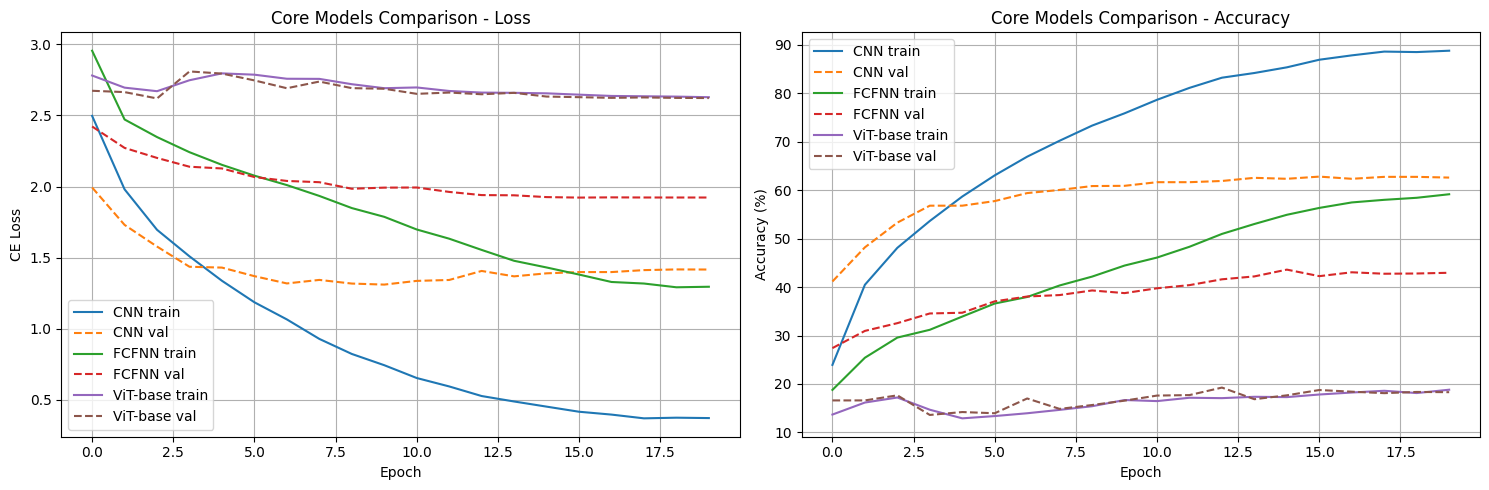

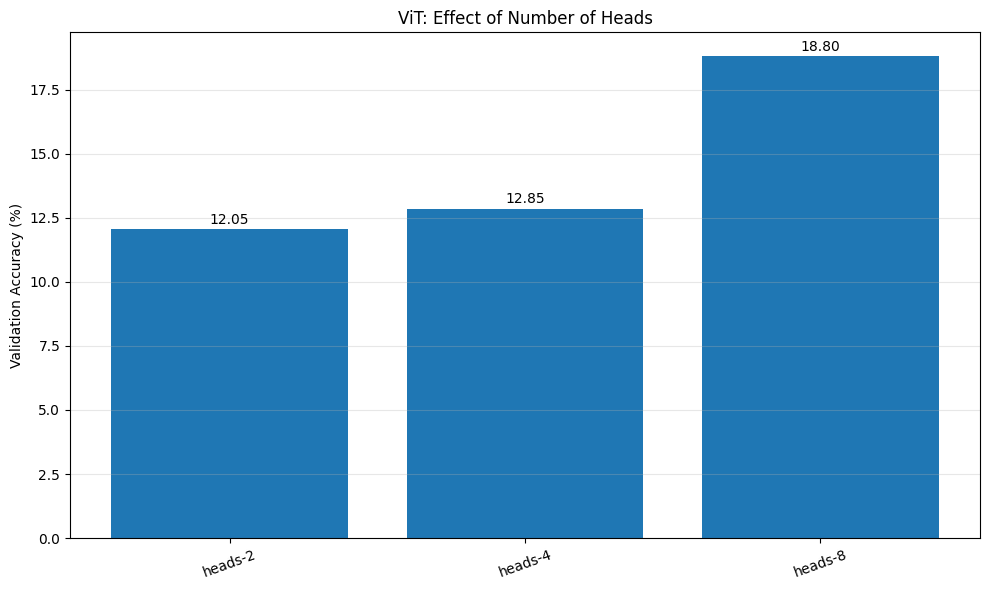

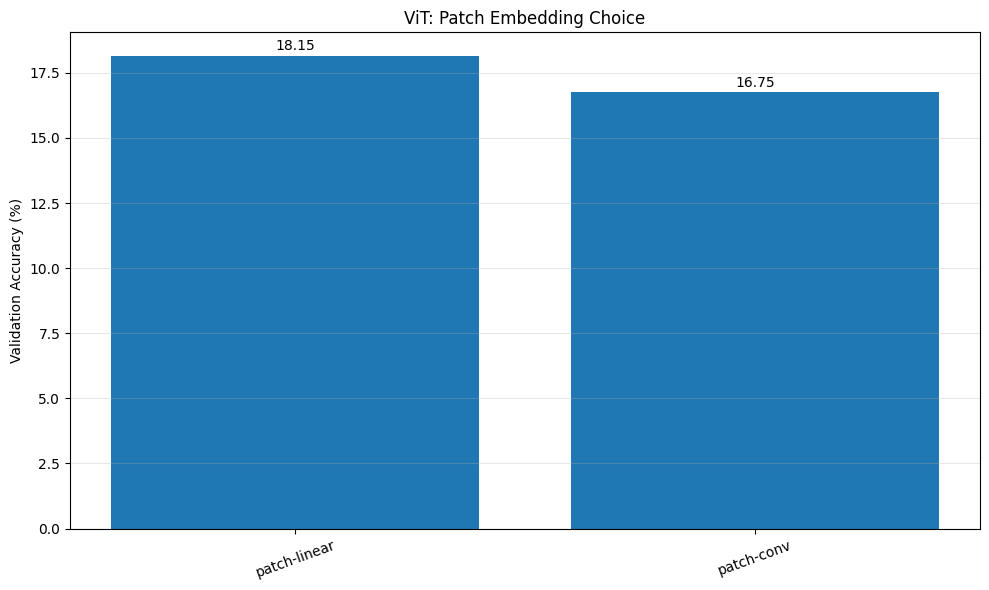

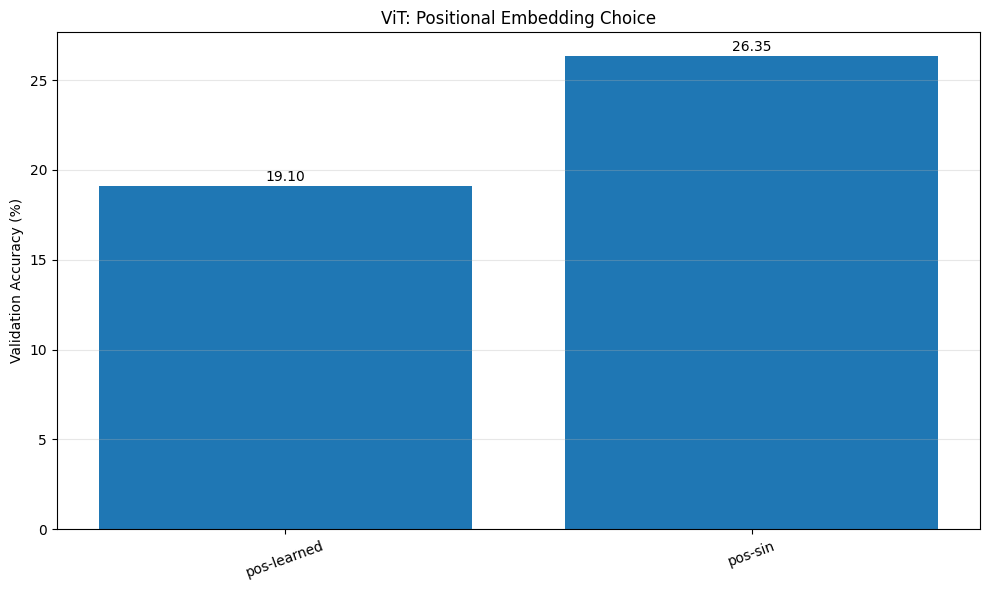


FINAL VALIDATION ACCURACY SUMMARY
CNN                 :  62.60%
FCFNN               :  42.95%
ViT-base            :  18.30%
heads-2             :  12.05%
heads-4             :  12.85%
heads-8             :  18.80%
patch-linear        :  18.15%
patch-conv          :  16.75%
pos-learned         :  19.10%
pos-sin             :  26.35%


In [2]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----------------------------
# Utilities
# ----------------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

# CIFAR-100 stats (better than ImageNet stats for this data)
CIFAR_MEAN = np.array([0.5071, 0.4867, 0.4408], dtype=np.float32)
CIFAR_STD  = np.array([0.2675, 0.2565, 0.2761], dtype=np.float32)

def normalize_batch(x):
    # x in [0,1] float32
    return (x - CIFAR_MEAN) / CIFAR_STD

def load_cifar100_subset(num_classes=20):
    """Return (x_train, y_train), (x_test, y_test), chosen_classes (first N)"""
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode="fine")
    chosen = list(range(num_classes))
    mask_tr = np.isin(y_train.flatten(), chosen)
    mask_te = np.isin(y_test.flatten(), chosen)
    x_train, y_train = x_train[mask_tr], y_train[mask_tr]
    x_test,  y_test  = x_test[mask_te],  y_test[mask_te]

    # Re-map labels to 0..num_classes-1 for convenience
    remap = {c:i for i,c in enumerate(chosen)}
    y_train = np.vectorize(remap.get)(y_train.flatten()).astype(np.int32)
    y_test  = np.vectorize(remap.get)(y_test.flatten()).astype(np.int32)
    return (x_train, y_train), (x_test, y_test), chosen

def make_datasets(batch_size=64, num_classes=20, shuffle=True):
    (x_train, y_train), (x_test, y_test), chosen = load_cifar100_subset(num_classes)
    print("Chosen classes:", chosen)
    print("Train shape:", x_train.shape, "Test shape:", x_test.shape)

    # to float [0,1]
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0

    AUTOTUNE = tf.data.AUTOTUNE

    def prep(x, y):
        x = normalize_batch(x)
        return x, y

    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    if shuffle:
        ds_train = ds_train.shuffle(buffer_size=len(x_train), seed=42)
    ds_train = ds_train.batch(batch_size).map(prep, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    ds_test = ds_test.batch(batch_size).map(prep, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    return ds_train, ds_test

def count_params_tf(model):
    return np.sum([np.prod(v.shape) for v in model.trainable_variables])

# ----------------------------
# ViT Components (Keras)
# ----------------------------
def sinusoidal_positional_encoding(n_positions, dim):
    """Return [n_positions, dim] sinusoidal table (numpy)."""
    position = np.arange(n_positions)[:, None]
    div_term = np.exp(np.arange(0, dim, 2) * (-math.log(10000.0) / dim))
    pe = np.zeros((n_positions, dim), dtype=np.float32)
    pe[:, 0::2] = np.sin(position * div_term)
    if dim % 2 == 1:
        pe[:, 1::2] = np.cos(position * div_term[:-1])
    else:
        pe[:, 1::2] = np.cos(position * div_term)
    return pe

class PatchEmbedLinear(layers.Layer):
    """Linear projection of flattened non-overlapping patches."""
    def __init__(self, img_size=32, patch_size=4, in_ch=3, embed_dim=384, **kwargs):
        super().__init__(**kwargs)
        assert img_size % patch_size == 0
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_ch = in_ch
        self.embed_dim = embed_dim
        self.grid = img_size // patch_size
        self.proj = layers.Dense(embed_dim)

    def call(self, x):
        # x: [B, H, W, C]
        ps = self.patch_size
        # Extract non-overlapping patches
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, ps, ps, 1],
            strides=[1, ps, ps, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )  # [B, grid, grid, ps*ps*C]
        B, G1, G2, D = tf.unstack(tf.shape(patches))
        patches = tf.reshape(patches, [B, G1*G2, D])  # [B, N, C*ps*ps]
        return self.proj(patches)  # [B, N, embed_dim]

class PatchEmbedConv(layers.Layer):
    """Conv2D with kernel=stride=patch_size to get patch embeddings efficiently."""
    def __init__(self, img_size=32, patch_size=4, in_ch=3, embed_dim=384, **kwargs):
        super().__init__(**kwargs)
        assert img_size % patch_size == 0
        self.proj = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)
        self.grid = img_size // patch_size

    def call(self, x):
        x = self.proj(x)  # [B, H/ps, W/ps, D]
        B = tf.shape(x)[0]
        N = tf.shape(x)[1] * tf.shape(x)[2]
        D = tf.shape(x)[3]
        x = tf.reshape(x, [B, N, D])  # [B, N, D]
        return x

class ViTEncoderBlock(layers.Layer):
    def __init__(self, embed_dim=384, num_heads=6, mlp_ratio=4.0, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn  = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.drop1 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp   = keras.Sequential([
            layers.Dense(int(embed_dim * mlp_ratio), activation=keras.activations.gelu),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout),
        ])

    def call(self, x, training=False):
        # Pre-norm
        h = self.norm1(x)
        attn_out = self.attn(h, h, training=training)
        x = x + self.drop1(attn_out, training=training)
        h = self.norm2(x)
        x = x + self.mlp(h, training=training)
        return x

# class VisionTransformer(keras.Model):
#     def __init__(
#         self,
#         img_size=32,
#         patch_size=4,
#         in_ch=3,
#         num_classes=20,
#         embed_dim=384,
#         depth=6,
#         num_heads=6,
#         mlp_ratio=4.0,
#         dropout=0.0,
#         patch_embed_type='conv',   # 'conv' or 'linear'
#         pos_embed_type='learned',  # 'learned' or 'sin'
#         **kwargs
#     ):
#         super().__init__(**kwargs)
#         # Patch embedding
#         if patch_embed_type == 'conv':
#             self.patch_embed = PatchEmbedConv(img_size, patch_size, in_ch, embed_dim)
#         else:
#             self.patch_embed = PatchEmbedLinear(img_size, patch_size, in_ch, embed_dim)

#         self.grid = img_size // patch_size
#         self.num_patches = self.grid * self.grid
#         self.embed_dim = embed_dim
#         self.pos_embed_type = pos_embed_type

#         # Class token
#         self.cls_token = self.add_weight(
#             "cls_token", shape=(1, 1, embed_dim),
#             initializer=keras.initializers.TruncatedNormal(stddev=0.02), trainable=True
#         )

#         # Positional embedding
#         if pos_embed_type == 'learned':
#             self.pos_embed = self.add_weight(
#                 "pos_embed", shape=(1, self.num_patches + 1, embed_dim),
#                 initializer=keras.initializers.TruncatedNormal(stddev=0.02), trainable=True
#             )
#         else:
#             pe = sinusoidal_positional_encoding(self.num_patches + 1, embed_dim)
#             self.pe_const = tf.convert_to_tensor(pe[None, ...])  # [1, N+1, D]

#         # Transformer blocks
#         self.blocks = [ViTEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)]
#         self.norm = layers.LayerNormalization(epsilon=1e-6)
#         self.head = layers.Dense(num_classes,
#                                  kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02))

#     def call(self, x, training=False):
#         # x: [B,H,W,C]
#         B = tf.shape(x)[0]
#         x = self.patch_embed(x)  # [B, N, D]
#         cls = tf.repeat(self.cls_token, repeats=B, axis=0)  # [B,1,D]
#         x = tf.concat([cls, x], axis=1)  # [B, N+1, D]

#         if self.pos_embed_type == 'learned':
#             x = x + self.pos_embed
#         else:
#             x = x + self.pe_const

#         for blk in self.blocks:
#             x = blk(x, training=training)
#         x = self.norm(x, training=training)
#         cls_out = x[:, 0]  # [B, D]
#         logits = self.head(cls_out, training=training)  # [B, num_classes]
        # return logits

class VisionTransformer(keras.Model):
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_ch=3,
        num_classes=20,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mlp_ratio=4.0,
        dropout=0.0,
        patch_embed_type='conv',   # 'conv' or 'linear'
        pos_embed_type='learned',  # 'learned' or 'sin'
        **kwargs
    ):
        super().__init__(**kwargs)
        # Patch embedding
        if patch_embed_type == 'conv':
            self.patch_embed = PatchEmbedConv(img_size, patch_size, in_ch, embed_dim)
        else:
            self.patch_embed = PatchEmbedLinear(img_size, patch_size, in_ch, embed_dim)

        self.grid = img_size // patch_size
        self.num_patches = self.grid * self.grid
        self.embed_dim = embed_dim
        self.pos_embed_type = pos_embed_type

        # Class token (use name=... to avoid add_weight shape error)
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, embed_dim),
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
        )

        # Positional embedding
        if pos_embed_type == 'learned':
            self.pos_embed = self.add_weight(
                name="pos_embed",
                shape=(1, self.num_patches + 1, embed_dim),
                initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                trainable=True,
            )
        else:
            pe = sinusoidal_positional_encoding(self.num_patches + 1, embed_dim)
            self.pe_const = tf.convert_to_tensor(pe[None, ...])  # [1, N+1, D]

        # Transformer blocks
        self.blocks = [
            ViTEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ]
        self.norm = layers.LayerNormalization(epsilon=1e-6)

        # If you use mixed precision, keep logits in float32: dtype="float32"
        self.head = layers.Dense(
            num_classes,
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            # dtype="float32",
        )

    def call(self, x, training=False):
        # x: [B,H,W,C]
        B = tf.shape(x)[0]
        x = self.patch_embed(x)  # [B, N, D]
        cls = tf.repeat(self.cls_token, repeats=B, axis=0)  # [B,1,D]
        x = tf.concat([cls, x], axis=1)  # [B, N+1, D]

        if self.pos_embed_type == 'learned':
            x = x + self.pos_embed
        else:
            x = x + self.pe_const

        for blk in self.blocks:
            x = blk(x, training=training)
        x = self.norm(x, training=training)
        cls_out = x[:, 0]  # [B, D]
        logits = self.head(cls_out, training=training)  # [B, num_classes]
        return logits

# ----------------------------
# Baseline Models (Keras)
# ----------------------------
def build_small_cnn(num_classes=20, img_size=32):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs, name="SmallCNN")

def build_fcfnn(num_classes=20, img_size=32):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs, name="FCFNN")

# ----------------------------
# Train & Evaluation
# ----------------------------
@dataclass
class TrainConfig:
    epochs: int = 20
    lr: float = 1e-3

def compile_with_cosine_decay(model, steps_per_epoch, cfg: TrainConfig):
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=cfg.lr,
        decay_steps=cfg.epochs * steps_per_epoch
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

def fit_and_history(model, ds_train, ds_val, cfg: TrainConfig, name="Model"):
    steps_per_epoch = tf.data.experimental.cardinality(ds_train).numpy()
    compile_with_cosine_decay(model, steps_per_epoch, cfg)
    print(f"\n=== Training {name} ===")
    h = model.fit(ds_train, validation_data=ds_val, epochs=cfg.epochs, verbose=2)
    return {
        "train_loss": h.history["loss"],
        "val_loss": h.history["val_loss"],
        "train_acc": [a*100 for a in h.history["acc"]],
        "val_acc": [a*100 for a in h.history["val_acc"]],
    }, model

def plot_curves(histories, title="Training Curves"):
    plt.figure(figsize=(15, 5))
    # Loss
    plt.subplot(1, 2, 1)
    for name, h in histories.items():
        plt.plot(h['train_loss'], label=f"{name} train")
        plt.plot(h['val_loss'], linestyle='--', label=f"{name} val")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("CE Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    for name, h in histories.items():
        plt.plot(h['train_acc'], label=f"{name} train")
        plt.plot(h['val_acc'], linestyle='--', label=f"{name} val")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def bar_plot(metric_dict, title, ylabel):
    names = list(metric_dict.keys())
    vals = [metric_dict[k] for k in names]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, vals)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=20)
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, vals):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{val:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# ----------------------------
# Experiment runners
# ----------------------------
def train_vit_variant(name, ds_train, ds_val,
                      patch_size=4, embed_dim=256, depth=6, num_heads=8,
                      patch_embed_type='conv', pos_embed_type='learned',
                      num_classes=20, epochs=15, lr=1e-3):
    model = VisionTransformer(
        img_size=32,
        patch_size=patch_size,
        in_ch=3,
        num_classes=num_classes,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        mlp_ratio=4.0,
        dropout=0.1,
        patch_embed_type=patch_embed_type,
        pos_embed_type=pos_embed_type,
        name=f"ViT-{name}"
    )
    cfg = TrainConfig(epochs=epochs, lr=lr)
    hist, model = fit_and_history(model, ds_train, ds_val, cfg, name=f"ViT-{name}")
    return hist, model

def main():
    batch_size = 64
    epochs = 20
    ds_train, ds_val = make_datasets(batch_size=batch_size, num_classes=20, shuffle=True)

    histories = {}

    # CNN
    cnn = build_small_cnn(num_classes=20, img_size=32)
    hist_cnn, cnn = fit_and_history(cnn, ds_train, ds_val, TrainConfig(epochs=epochs, lr=1e-3), name="CNN")
    histories["CNN"] = hist_cnn
    print("CNN params:", f"{count_params_tf(cnn):,}")

    # FCFNN
    fcf = build_fcfnn(num_classes=20, img_size=32)
    hist_fcf, fcf = fit_and_history(fcf, ds_train, ds_val, TrainConfig(epochs=epochs, lr=1e-3), name="FCFNN")
    histories["FCFNN"] = hist_fcf
    print("FCFNN params:", f"{count_params_tf(fcf):,}")

    # ViT base
    hist_vit_base, vit_base = train_vit_variant(
        "base", ds_train, ds_val,
        patch_size=4, embed_dim=256, depth=6, num_heads=8,
        patch_embed_type='conv', pos_embed_type='learned',
        num_classes=20, epochs=epochs, lr=1e-3
    )
    histories["ViT-base"] = hist_vit_base
    print("ViT-base params:", f"{count_params_tf(vit_base):,}")

    # Ablation: number of heads
    head_settings = [2, 4, 8]
    head_results = {}
    for hnum in head_settings:
        print(f"\n--- ViT heads={hnum} ---")
        hist, _ = train_vit_variant(
            f"heads{hnum}", ds_train, ds_val,
            patch_size=4, embed_dim=256, depth=6, num_heads=hnum,
            patch_embed_type='conv', pos_embed_type='learned',
            num_classes=20, epochs=epochs, lr=1e-3
        )
        histories[f"ViT-h{hnum}"] = hist
        head_results[f"heads-{hnum}"] = hist["val_acc"][-1]

    # Ablation: patch embedding
    pe_results = {}
    for pe_type in ["linear", "conv"]:
        print(f"\n--- ViT patch_embed={pe_type} ---")
        hist, _ = train_vit_variant(
            f"patch-{pe_type}", ds_train, ds_val,
            patch_size=4, embed_dim=256, depth=6, num_heads=8,
            patch_embed_type=pe_type, pos_embed_type='learned',
            num_classes=20, epochs=epochs, lr=1e-3
        )
        histories[f"ViT-patch-{pe_type}"] = hist
        pe_results[f"patch-{pe_type}"] = hist["val_acc"][-1]

    # Ablation: positional embedding
    pos_results = {}
    for pos_type in ["learned", "sin"]:
        print(f"\n--- ViT pos_embed={pos_type} ---")
        hist, _ = train_vit_variant(
            f"pos-{pos_type}", ds_train, ds_val,
            patch_size=4, embed_dim=256, depth=6, num_heads=8,
            patch_embed_type='conv', pos_embed_type=pos_type,
            num_classes=20, epochs=epochs, lr=1e-3
        )
        histories[f"ViT-pos-{pos_type}"] = hist
        pos_results[f"pos-{pos_type}"] = hist["val_acc"][-1]

    # Plots
    print("\n=== Creating Plots ===")
    core_hist = {k: v for k, v in histories.items() if k in ["CNN", "FCFNN", "ViT-base"]}
    plot_curves(core_hist, title="Core Models Comparison")

    bar_plot(head_results, "ViT: Effect of Number of Heads", "Validation Accuracy (%)")
    bar_plot(pe_results,   "ViT: Patch Embedding Choice",   "Validation Accuracy (%)")
    bar_plot(pos_results,  "ViT: Positional Embedding Choice", "Validation Accuracy (%)")

    # Final summary
    summary = {
        "CNN": histories["CNN"]["val_acc"][-1],
        "FCFNN": histories["FCFNN"]["val_acc"][-1],
        "ViT-base": histories["ViT-base"]["val_acc"][-1],
        **head_results, **pe_results, **pos_results
    }
    print("\n" + "="*50)
    print("FINAL VALIDATION ACCURACY SUMMARY")
    print("="*50)
    for k, v in summary.items():
        print(f"{k:20s}: {v:6.2f}%")
    print("="*50)

if __name__ == "__main__":
    main()
